Smoking behaviour
-----------------------------
- questionnaire on every evening 
- number of cig smoked during the day
- yes/no stub out cig before finishing it in order to smoke less
- yes/no stop yourself having a cig to smoke less
- if zero cig, ask why

Following study hypotheses we want here to look at micro-indicators of behaviour change, including: 
- being more likely to report making a quit attempt over the 4-week period;
- more frequently reporting forgoing cigarettes over the 4-week period;
- a greater intention to quit smoking at the end of the 4-week period;
- a reduction in the number of cigarettes smoked over the 4-week period. 

Participants who report not smoking any cigarettes on at least one of the study days and report this being because they were trying to quit smoking will be considered having made a quit attempt during the study period. 

CPD will be assessed using the daily smoked cigarette reports completed in the evening report. We anticipate that any decrease in reporting cigarettes smoked over the study period will be the same between the two conditions. We will exclude data collected on the baseline day (Day 0) and the final day (Day 28: Table 2) as participants will start and end the study at different times during those days.

    • model for quit attempts: quit_attempt ~ time + condition + (1 + time|subject)
    • model for forgoing cigarettes: FC ~ time + condition + (1 + time|subject)
    • model for intention to quit: quit_intention ~ time + condition + (1 + time|subject)
    • model for CPD: CPD ~ time + condition + (1 + time|subject)

# Preprocessing data


In [1]:
library(tidyverse)
library(here)
library(lubridate)
library(lme4)
library(mice)
library(sjPlot)
library(effects)


cond_file = "~/Documents/scripts-local/skyline/BEHAVIOUR/Analysis/expe_condition_final.csv"


save_figure = here::here("Figures")

files_eff_eve <-dir(path=here::here("data") , pattern = "*.csv") 

evening_scores <-read.csv(here::here("data", files_eff_eve), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)

# condition file
cond <- read_csv(cond_file)

# rename columns
# 1 = Yes, 2 =No

evening_scores<-rename(evening_scores, date=EndDate, completed=Finished,
                      ID=Q1, 
                      NCig=Q4, 
                      StubCig=Q5, 
                      StopCig=Q6, 
                      WhyNoCig=Q7,
                      WhyNoCig_other=Q7_5_TEXT
                      )



# select only columns of interest

evening_scores<-select(evening_scores, ID, date, completed,
                       NCig, StubCig, StopCig,
                      WhyNoCig, WhyNoCig_other)

#remove additional header
evening_scores<-tail(evening_scores, -2)


# get the experiment condition file with all pp IDs
cond <-rename(cond, ID = "Subject ID", 
              condition = "Condition = Intervention",
              removed= "REMOVED")
cond$ID<-as.factor(cond$ID)

evening_scores$ID<-as.factor(evening_scores$ID)
tmp<-full_join(cond, evening_scores)

remove(evening_scores)
evening_scores<-tmp
evening_scores$ID<-as.factor(evening_scores$ID)

#recode condition to human names
evening_scores$condition<-recode(evening_scores$condition, '0' = "control", '1' = "intervention")

#Replace missing values and keep only participants who were not removed
evening_scores$removed<-evening_scores$removed %>% replace(is.na(.), 0)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

here() starts at /home/claire/Documents/scripts-local/skyline/BEHAVIOUR/Analysis/Cig_per_day


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Attaching package: ‘mice’


The following object is masked from ‘package:stats’:

    filter


The following objects are masked from ‘package:base’:

    cbind, rbind


Install package "strengejacke" from GitHub (`devtools::install_github("stre

In [2]:
# remove NA in  scores
#which(is.na(evening_scores$StubCig))

#evening_scores<-drop_na(evening_scores, StubCig)

In [3]:
# remove lines not associated with a real participant ID
which(is.na(evening_scores$condition))

evening_scores<-drop_na(evening_scores, condition)

[1] 5705 5706 5707 5708 5709 5710 5711 5712 5713 5714 5715 5716 5717 5718 5719
[16] 5720 5721 5722 5723 5724 5725 5726 5727 5728 5729 5730 5731 5732 5733 5734
[31] 5735 5736 5737 5738 5739 5740 5741 5742 5743 5744 5745 5746 5747 5748 5749
[46] 5750 5751 5752 5753 5754 5755 5756 5757 5758 5759 5760 5761 5762 5763 5764
[61] 5765

In [4]:
# filter to keep participants who did at least 80% of surveys
evening_scores<-evening_scores%>%filter(Good == 1)

df<-evening_scores

df$NCig <- as.numeric(df$NCig)
df$StubCig<- as.numeric(df$StubCig)
df$StopCig<- as.numeric(df$StopCig)

#which(is.na(df$NCig))
#df<-drop_na(df,NCig)

In [5]:
df<-select(df, -'removed', -'Finished', -'Interview', -'Notes', -"completed" )
df<-select(df, -'Starting Date', -'day_msg',  -'No Compliance', -'Email reminder poor perf', -'eve_msg', -'ev3days')

In [6]:
df <-df %>% 
  group_by(ID) %>% 
  mutate(n_day = row_number()) %>%
  select(ID, n_day, everything()) %>% 
  ungroup()  


In [7]:
# create factor time
df$n_day<-as.factor(df$n_day)

In [8]:
levels(df$n_day)

[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20" "21" "22" "23" "24" "25" "26" "27" "28" "29" "30"
[31] "31" "32" "33" "34" "35"

In [9]:
# remove days > 28 - might need to look into that later
df<-df[! df$n_day %in% c("29", "30",  '30', '31', '32', '33', '34', '35'),]

In [10]:
df$condition<-as.factor(df$condition)

In [11]:
df<-df %>% group_by(condition) %>% 
mutate(n_pp=n_distinct(ID)) %>% 
    ungroup()

Saving 6.67 x 6.67 in image



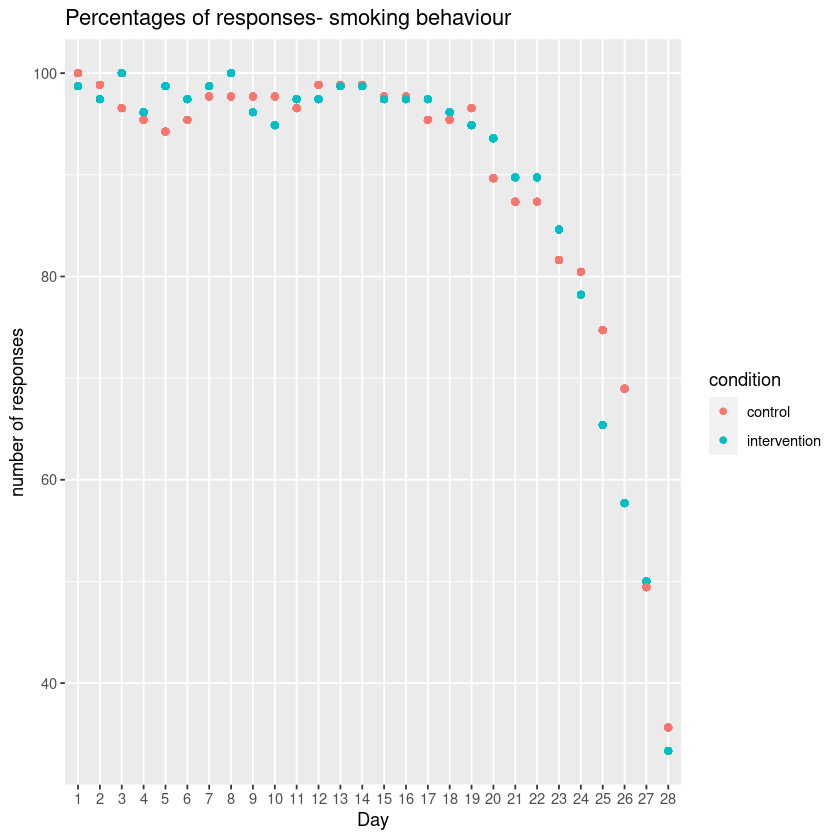

In [12]:
# count how many of each day per condition (ie.did the pp completed the survey)
n_rep <- df %>% group_by(condition, n_day) %>%
 mutate(count=sum(!is.na(NCig))) %>% 
    ungroup()
n_rep <-n_rep %>% drop_na()

#n_rep$EEG<-as.factor(n_rep$EEG)

# plot
ggplot(data= n_rep, aes(x = n_day, y=count/n_pp*100) ) +
  geom_point(mapping = aes(colour = condition) ) +
  ggtitle("Percentages of responses- smoking behaviour")+
  xlab('Day')+ ylab('number of responses')#+ 
 ggsave('percent_resp_per_day_all.jpg', plot =last_plot(), dpi =300, path= save_figure)
 

Saving 6.67 x 6.67 in image



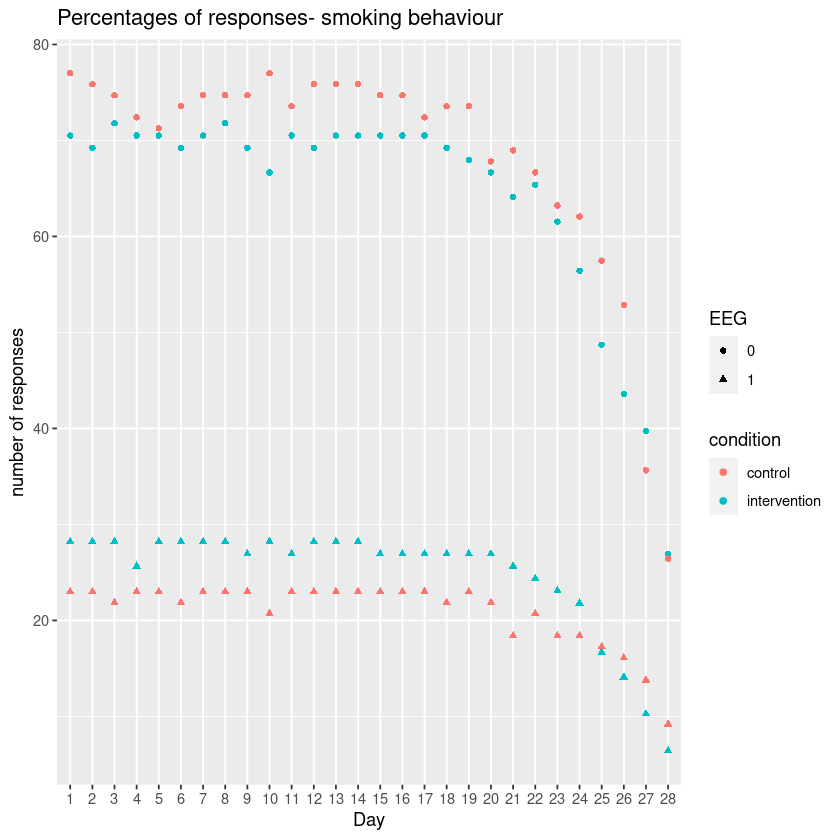

In [13]:
# count how many of each day per condition
n_rep <- df %>% group_by(condition, n_day, EEG) %>%
  mutate(count=sum(!is.na(NCig))) %>% 
    ungroup()
n_rep <-n_rep %>% drop_na()

n_rep$EEG<-as.factor(n_rep$EEG)

# plot
ggplot(data= n_rep, aes(x = n_day, y=count/n_pp*100)) +
  geom_point(mapping = aes(colour = condition, shape=EEG) ) +
  ggtitle("Percentages of responses- smoking behaviour")+
  xlab('Day')+ ylab('number of responses')#+ 
 ggsave('percent_resp_per_day_all_eeg.jpg', plot =last_plot(), dpi =300, path= save_figure)
 

## Now check for anomalies in how data were entered


In [14]:
# check for outliers/anomalie data -> check if mistake on 1 day
df %>% filter(NCig>50) # 50 as a guess 


ID,n_day,Good,condition,EEG,date,NCig,StubCig,StopCig,WhyNoCig,WhyNoCig_other,n_pp
<fct>,<fct>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
599,26,1,control,0,2019-08-16 21:49:15,599,2,2,,,87
1018,8,1,control,0,2019-12-27 23:07:10,1018,1,2,,,87
295,24,1,control,1,2020-01-13 21:03:18,295,1,1,,,87
2364,25,1,control,0,2020-03-15 00:51:59,2364,2,2,,,87
1496,24,1,control,0,2020-03-12 21:21:18,1496,2,2,,,87
173,17,1,intervention,0,2019-07-31 22:57:08,173,2,2,,,78
173,20,1,intervention,0,2019-08-03 21:30:45,173,2,2,,,78
313,11,1,control,0,2019-07-11 22:27:00,313,1,NA,,,87


Seems to be an error where the participant's ID was entered instead of the number of cig smoked on at least one occasion

In [15]:
# replace these aberrant values by NA
df$NCig<-replace(df$NCig, df$NCig>50, NA)

# Reports of 0 cigarettes smoked on a day and quit attempt

Follow-up question: Why did you not smoke any cigarettes today?
Value for numeric responses:
- 1= I didn't have time
- 2= I didn't feel like smoking
- 3= I was in places where smoking was not allowed
- 4= I am trying to stop smoking
- 5 = others (see WhyNoCig_other)

"Participants who report not smoking any cigarettes on at least one of the study days and report this being because they were trying to quit smoking will be considered having made a quit attempt during the study period. "

In [61]:
# how many reported no cig on at least one day
nocig<-df %>% filter(NCig==0)  
n_distinct(nocig$ID)

[1] 12

In [62]:
# how many reported no cig because want to stop smoking
nocig<-nocig %>% filter(WhyNoCig ==4)
n_distinct(nocig$ID)

[1] 9

In [63]:
distinct(nocig, ID, `.keep_all` = TRUE) %>% filter(condition=='control')

ID,n_day,Good,condition,EEG,date,NCig,StubCig,StopCig,WhyNoCig,WhyNoCig_other,n_pp
<fct>,<fct>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
599,25,1,control,0,2019-08-15 21:09:38,0,2,1,4,,87
309,13,1,control,0,2019-08-03 21:02:32,0,2,2,4,,87
769,14,1,control,0,2019-07-27 21:02:35,0,2,1,4,,87


## Conclusion

12 participants reported not smoking any cigarette on at least one of the study days. Out of these, 9 reported not smoking because they were trying to quit smoking = made a quit attempt (6 were in the intervention group, 3 in the control group).

## Mixed Model quit attempt

model for quit attempts: quit_attempt ~ time + condition + (1 + time|subject)

In [66]:
mod_nocig<-lmer(NCig~n_day + condition +(1 + n_day|ID), data= nocig)

ERROR: Error: number of observations (=48) <= number of random effects (=144) for term (n_day | ID); the random-effects parameters and the residual variance (or scale parameter) are probably unidentifiable


# Reports of forgoing cigarettes 


H3: As compared to those in the control condition, those in the efficacy condition will display micro-indicators of behaviour change, including:  
 - more frequently reporting forgoing cigarettes (FC) over the 4-week period;  

Forgoing = forgoing stub + forgoing stop

Response code:
- 1 = yes
- 2 = no




How many forego in each condition?

In [19]:
df %>% group_by(condition) %>% 
summarise(Total_StopCig= sum(StopCig==1, na.rm=TRUE), 
         Total_StubCig= sum(StubCig==1, na.rm=TRUE), 
         Total_Forego = Total_StopCig+Total_StubCig)

`summarise()` ungrouping output (override with `.groups` argument)



condition,Total_StopCig,Total_StubCig,Total_Forego
<fct>,<int>,<int>,<int>
control,491,501,992
intervention,538,480,1018


The intervention group has more instances of stopping themselves from smoking and higher total forego report than control group

In [20]:
df_long<-pivot_longer(df, cols=starts_with("St"), names_to = "ForegoCig", 
             values_to = "NCigForego")

In [21]:
df_long$NCigForego<-as.factor(df_long$NCigForego)

In [22]:
freq_forego<-df_long %>% filter(!is.na(NCigForego))  %>% 
    group_by(condition, n_day)  %>% 
count(NCigForego) %>% 
mutate(rel.freq= round(100*n/sum(n),0)) 


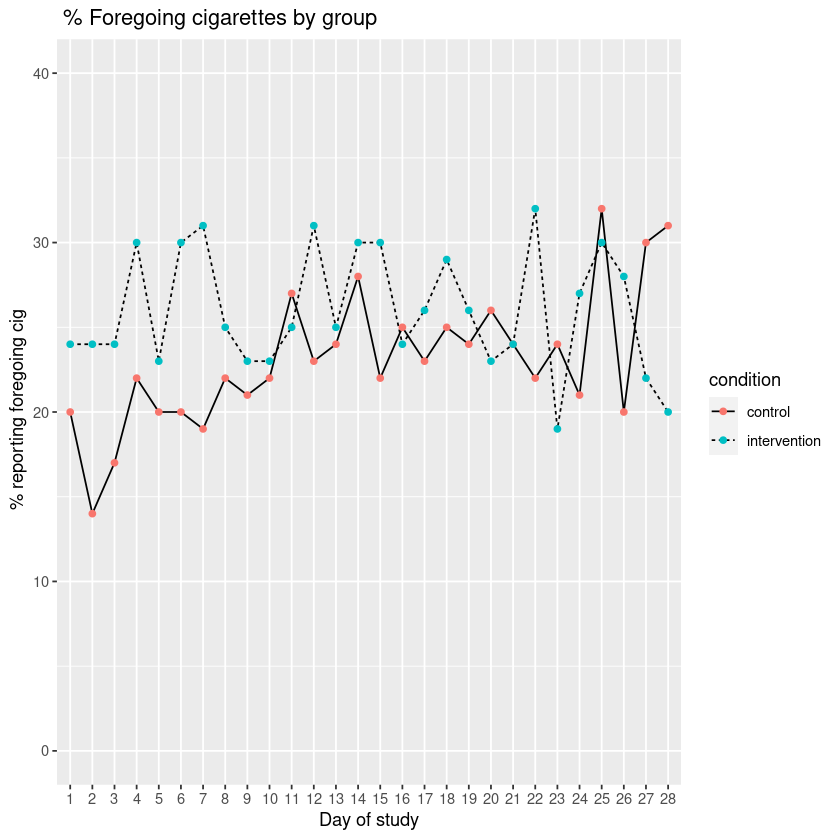

In [23]:
freq_forego %>% filter(NCigForego==1) %>% 
ggplot(aes(y=rel.freq, x=n_day, group=condition))+
geom_line(aes(linetype=condition))+
 geom_point(mapping = aes(colour = condition ) )+
ylim(0,40)+
ggtitle (" % Foregoing cigarettes by group")+
ylab(" % reporting foregoing cig")+
xlab("Day of study")


`geom_smooth()` using formula 'y ~ x'



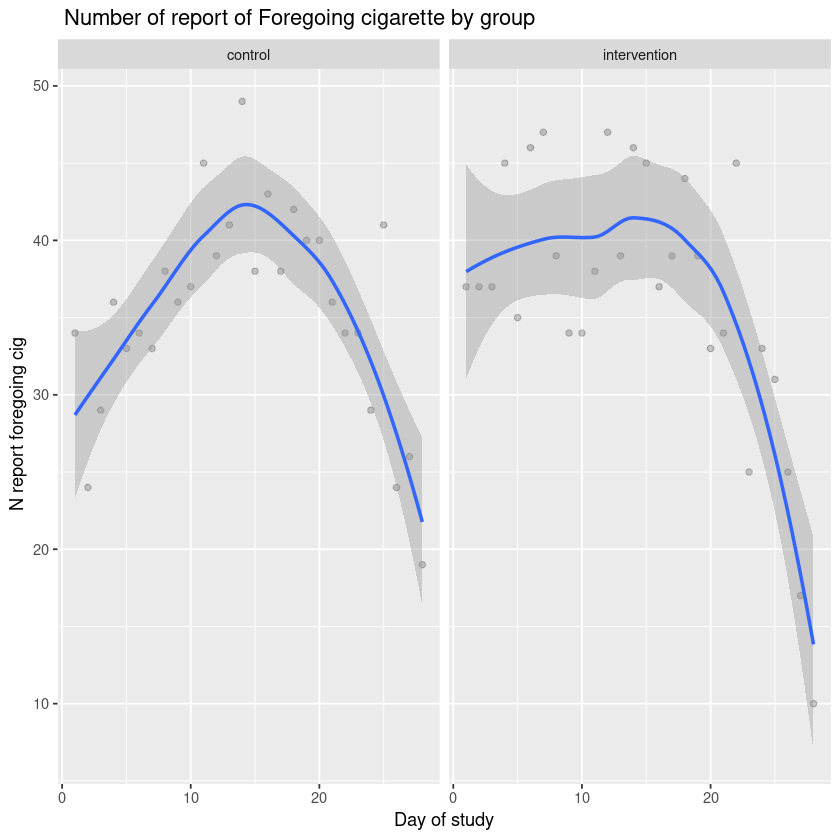

In [24]:
freq_forego %>% filter(NCigForego==1) %>% 
   ggplot(aes(y = n, x = as.numeric(n_day)))+
geom_point(alpha = 0.2)+
geom_smooth(method = "loess")+
facet_grid(~condition)+
ggtitle (" Number of report of Foregoing cigarette by group")+
ylab(" N report foregoing cig")+
xlab("Day of study")

##  Mixed Model Foregoing cigarettes

In [25]:
head(freq_forego)

condition,n_day,NCigForego,n,rel.freq
<fct>,<fct>,<fct>,<int>,<dbl>
control,1,1,34,20
control,1,2,140,80
control,2,1,24,14
control,2,2,148,86
control,3,1,29,17
control,3,2,139,83


In [26]:
head(df_long)

ID,n_day,Good,condition,EEG,date,NCig,WhyNoCig,WhyNoCig_other,n_pp,ForegoCig,NCigForego
<fct>,<fct>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<int>,<chr>,<fct>
339,1,1,control,1,2019-10-31 02:40:41,25,,,87,StubCig,1
339,1,1,control,1,2019-10-31 02:40:41,25,,,87,StopCig,2
339,2,1,control,1,2019-10-31 22:35:22,10,,,87,StubCig,2
339,2,1,control,1,2019-10-31 22:35:22,10,,,87,StopCig,1
339,3,1,control,1,2019-11-01 23:15:33,6,,,87,StubCig,2
339,3,1,control,1,2019-11-01 23:15:33,6,,,87,StopCig,2


In [27]:
df_long$ForegoCig<-as.factor(df_long$ForegoCig)

In [28]:
levels(df_long$ForegoCig)

as.numeric(df_long$ForegoCig)

[1] "StopCig" "StubCig"

[1] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
  [38] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
  [75] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 [112] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 [149] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 [186] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 [223] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 [260] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 [297] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 [334] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 [371] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 [408] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 [445] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 [482] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 [519] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 [556] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 [593] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 [630] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 [667] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 [704] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 [741] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 [778] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 [815] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 [852] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 [889] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 [926] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
 [963] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
[1000] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
[1037] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
[1074] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
[1111] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
[1148] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
[1185] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
[1222] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
[1259] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
[1296] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
[1333] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
[1370] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
[1407] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
[1444] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
[1481] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
[1518] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
[1555] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
[1592] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
[1629] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
[1666] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
[1703] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
[1740] 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1
[1777] 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
[1814] 1 2 1 2 1 2 1 2 1 2 1 2 1 2

In [29]:
stub_cig<-df_long %>% filter(as.numeric(ForegoCig)== 2 & !is.na(NCigForego))  %>%
    group_by(condition, n_day, ID)  

stub_cig<-select(stub_cig, ID, n_day, condition, NCigForego)

stub_cig<-rename(stub_cig, StubCig= NCigForego)



stub_cig$StubCig<-recode(stub_cig$StubCig, '1'=1, '2'=0 )

stub_cig$StubCig<-as.numeric(stub_cig$StubCig)
stub_cig$n_day<-as.numeric(stub_cig$n_day)


The value of StubCig is binary, participants either said "yes" (1) or "no" (2). We thus need to use a mixed effects logistic regression model.  

In [38]:
stub_mod<-glmer(StubCig~n_day + condition +(1 +n_day|ID), data=stub_cig, family=binomial)

summary(stub_mod)

Interpretation:
n_day positively and significantly predicts the probability of stubbing a cigarette. The effect of being in the intervention condition is not significant. 

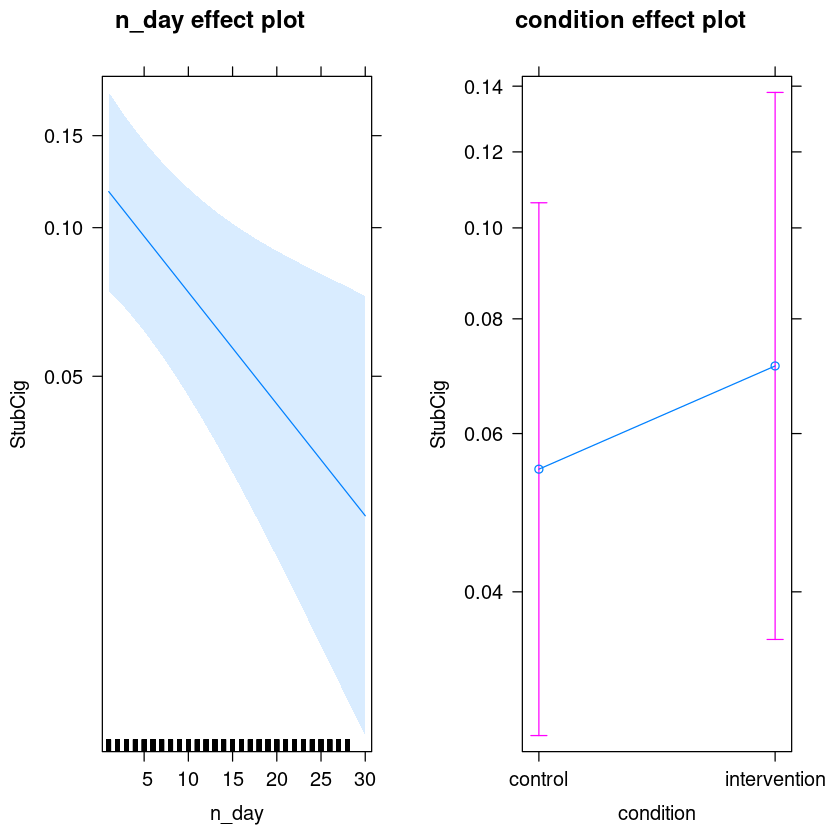

In [41]:
plot(allEffects(stub_mod))

**Note** y axis on both plots refers to probability of stubbing a cigarette

In [43]:
stop_cig<-df_long %>% filter(as.numeric(ForegoCig)== 1 & !is.na(NCigForego))  %>%
    group_by(condition, n_day, ID)  

stop_cig<-select(stop_cig, ID, n_day, condition, NCigForego)

stop_cig<-rename(stop_cig, StopCig= NCigForego)



stop_cig$StopCig<-recode(stop_cig$StopCig, '1'=1, '2'=0 )

stop_cig$StopCig<-as.numeric(stop_cig$StopCig)
stop_cig$n_day<-as.numeric(stop_cig$n_day)


In [44]:
stop_mod<-glmer(StopCig~n_day + condition +(1 +n_day|ID), data=stop_cig, family=binomial)

summary(stop_mod)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: StopCig ~ n_day + condition + (1 + n_day | ID)
   Data: stop_cig

     AIC      BIC   logLik deviance df.resid 
  2915.1   2953.1  -1451.6   2903.1     4112 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9186 -0.3134 -0.1112 -0.0874  4.7426 

Random effects:
 Groups Name        Variance Std.Dev. Corr 
 ID     (Intercept) 7.43810  2.7273        
        n_day       0.01133  0.1064   -0.14
Number of obs: 4118, groups:  ID, 165

Fixed effects:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)           -3.15599    0.39062  -8.079 6.51e-16 ***
n_day                  0.02240    0.01555   1.441   0.1497    
conditionintervention  1.00613    0.48472   2.076   0.0379 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) n_day 
n_day       -0.393       
cnd

Interpretation: Being in the intervention condition has a positive and significant effect on the probablity of stopping from having a cigarette. There is no significant effect of days spent in the experiment in that case.

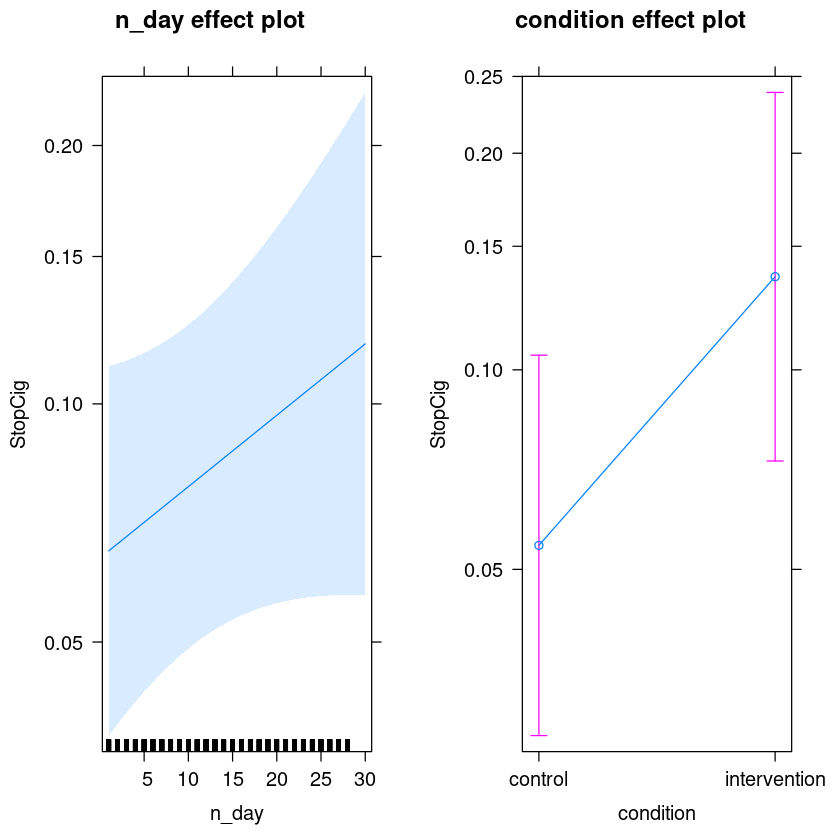

In [45]:
plot(allEffects(stop_mod))

**Note** y axis on both plots refers to probability of stopping from having a cigarette

Cigarettes per day (CPD)
=======================

CPD will be assessed using the daily smoked cigarette reports completed in the evening report. We anticipate that any decrease in reporting cigarettes smoked over the study period will be the same between the two conditions. We will exclude data collected on the baseline day (Day 0) and the final day (Day 28: Table 2) as participants will start and end the study at different times during those days.


- a reduction in the number of cigarettes smoked over the 4-week period.

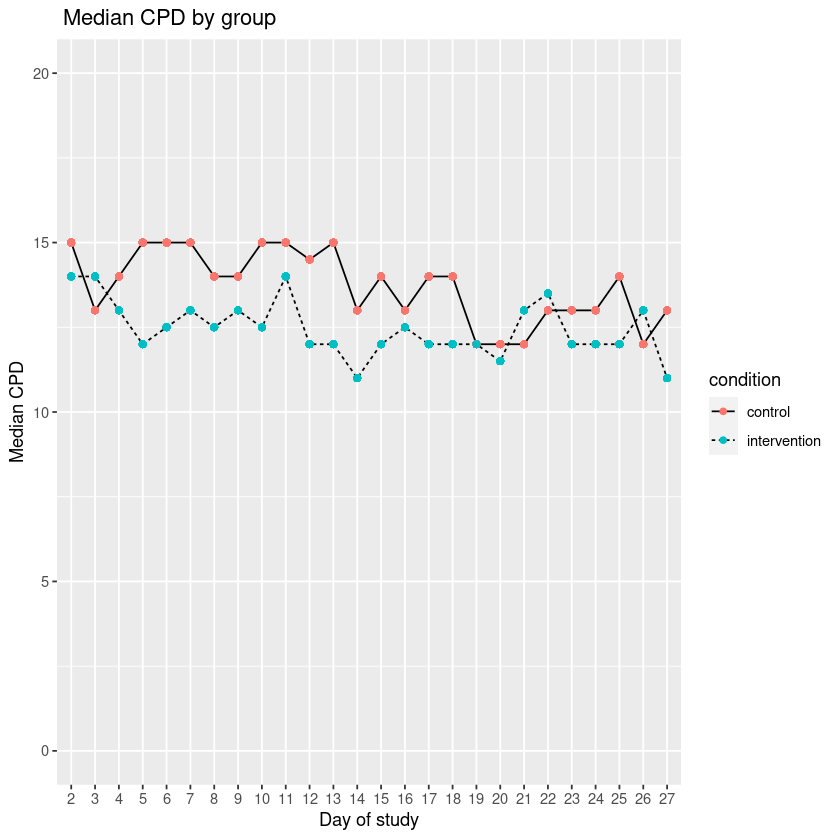

In [47]:
df %>%filter(as.numeric(n_day)!=1 & as.numeric(n_day)!=28) %>% 
        filter(!is.na(NCig))  %>% 
    group_by(condition, n_day)  %>%  
    mutate(mean_cpd= median(NCig), 
          sd_cpd=sd(NCig)) %>% 
ggplot(aes(y=mean_cpd, x=n_day, group=condition))+
#geom_errorbar(aes(ymin=mean_cpd-sd_cpd, 
#                  ymax=mean_cpd+sd_cpd), width=.1)+
geom_line(aes(linetype=condition))+
 geom_point(mapping = aes(colour = condition ) )+
ylim(0, 20)+
ggtitle (" Median CPD by group")+
ylab(" Median CPD ")+
xlab("Day of study")

Try using example from open-visualization 
https://github.com/jorvlan/open-visualizations/tree/v.1.0.0

`geom_smooth()` using formula 'y ~ x'



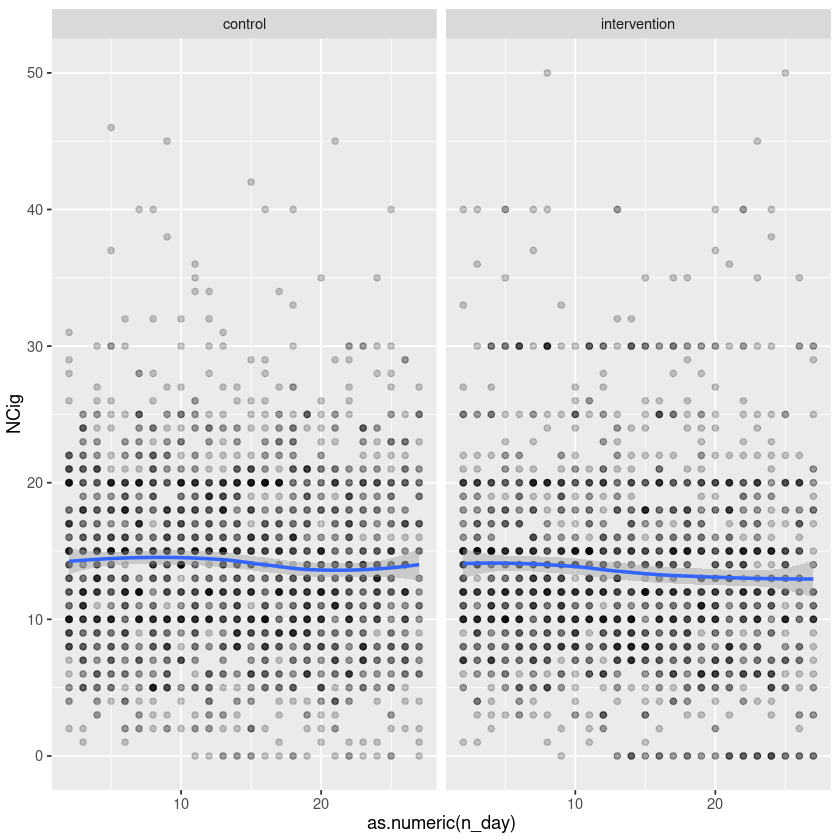

In [48]:
df %>%filter(as.numeric(n_day)!=1 & as.numeric(n_day)!=28) %>% 
        filter(!is.na(NCig))  %>% 
   ggplot(aes(y = NCig, x = as.numeric(n_day)))+
geom_point(alpha = 0.2)+
geom_smooth(method = "loess")+
facet_grid(~condition)

Modelling

From chat with Osama:
- use mice to impute missing data
- if including baseline and followup days create 2 time lag variables between baseline and day1 and day 28 and follow up:

 CPD ~ time + timelag + timelag_fwup + condition + (1 + time|subject) 

then see if these timelag variables have an effect on the model and if not, drop them


Where do missing data for number of cigarettes occur in our dataset:

,ID,n_day,Good,condition,EEG,date,WhyNoCig,WhyNoCig_other,n_pp,StubCig,StopCig,NCig,
4111,1,1,1,1,1,1,1,1,1,1,1,1,0
7,1,1,1,1,1,1,1,1,1,1,1,0,1
4,1,1,1,1,1,1,1,1,1,1,0,1,1
1,1,1,1,1,1,1,1,1,1,1,0,0,2
1,1,1,1,1,1,1,1,1,1,0,0,1,2
96,1,1,1,1,1,1,1,1,1,0,0,0,3
,0,0,0,0,0,0,0,0,0,97,102,104,303


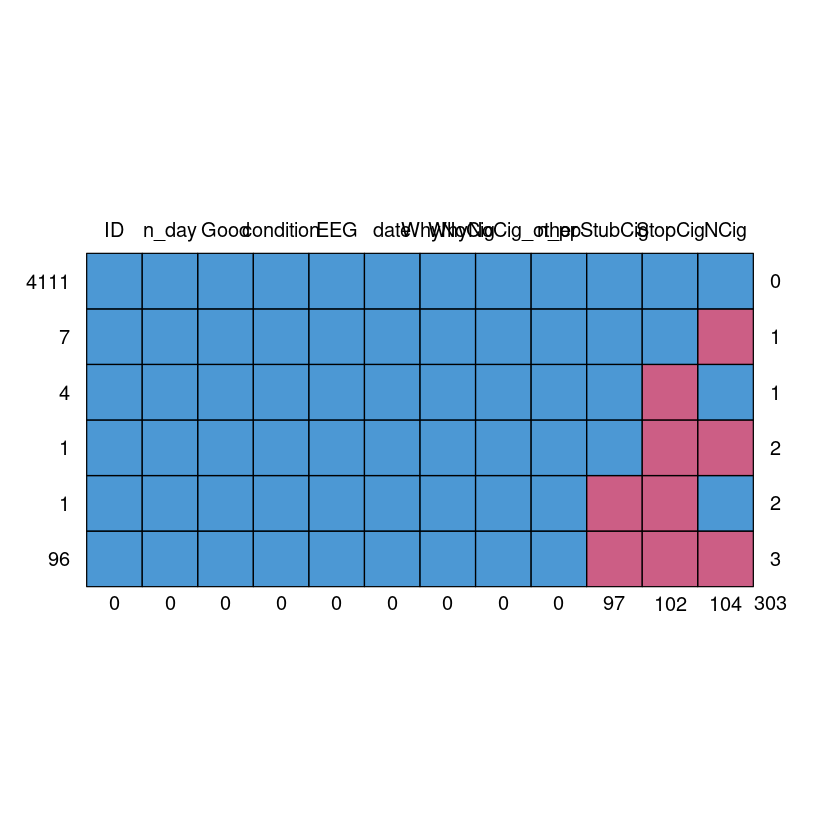

In [53]:
md.pattern(df)

In [54]:
df_ncig<-select(df, ID, n_day, condition, NCig)

now impute missing data:


In [56]:
imp<- mice(df_ncig, maxit=2, m=2)


 iter imp variable
  1   1  NCig*
  1   2  NCig*
  2   1  NCig*
  2   2  NCig*


Warning message:
“Number of logged events: 8”


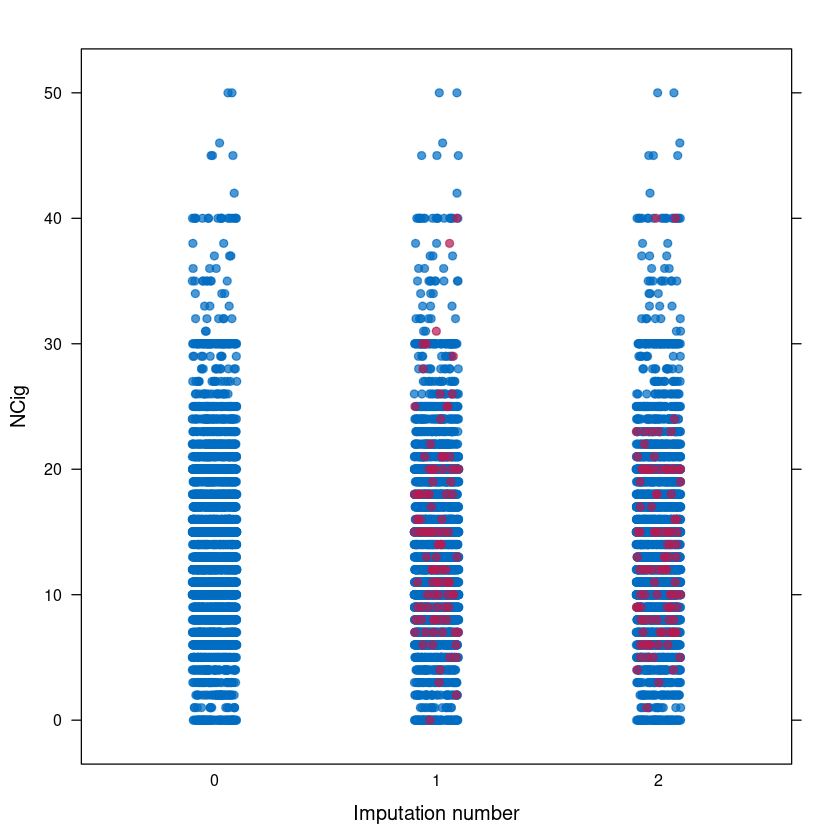

In [58]:
# inspect quality of imputations
stripplot(imp, NCig, pch = 19, xlab = "Imputation number")

In [59]:
fit<- with(imp, lmer(NCig~n_day + condition +(1 + n_day|ID)))


ERROR: Error: number of observations (=4220) <= number of random effects (=4620) for term (1 + n_day | ID); the random-effects parameters and the residual variance (or scale parameter) are probably unidentifiable


In [60]:
test<-lmer(NCig~n_day + condition +(1 + n_day|ID), data=df_ncig)

ERROR: Error: number of observations (=4116) <= number of random effects (=4620) for term (1 + n_day | ID); the random-effects parameters and the residual variance (or scale parameter) are probably unidentifiable


In [ ]:
#fit

In [ ]:
?lme4::convergence

In [ ]:
#lmer(NCig~n_day + condition +(1 + n_day|ID), imp)

In [ ]:
#write_csv(df, 'df.csv')